In [1]:
import numpy as np
import os
from tensorflow import keras
import kerasncp as kncp
import matplotlib.pyplot as plt
import seaborn as sns

data_x.shape:  (1, 48, 2)
data_y.shape:  (1, 48, 1)


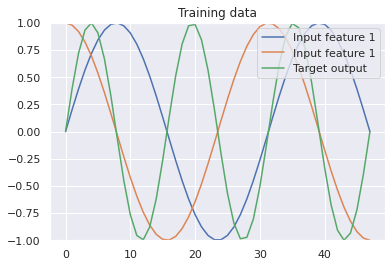

In [10]:
N = 48 # Length of the time-series
# Input feature is a sine and a cosine wave
data_x = np.stack(
    [np.sin(np.linspace(0, 3 * np.pi, N)), np.cos(np.linspace(0, 3 * np.pi, N))], axis=1
)
data_x = np.expand_dims(data_x, axis=0).astype(np.float32)  # Add batch dimension
# Target output is a sine with double the frequency of the input signal
data_y = np.sin(np.linspace(0, 6 * np.pi, N)).reshape([1, N, 1]).astype(np.float32)
print("data_x.shape: ", str(data_x.shape))
print("data_y.shape: ", str(data_y.shape))

# Let's visualize the training data
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(data_x[0, :, 0], label="Input feature 1")
plt.plot(data_x[0, :, 1], label="Input feature 1")
plt.plot(data_y[0, :, 0], label="Target output")
plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

In [11]:
fc_wiring = kncp.wirings.FullyConnected(8, 1)  # 8 units, 1 of which is a motor neuron
ltc_cell = kncp.LTCCell(fc_wiring)

model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        keras.layers.RNN(ltc_cell, return_sequences=True),
    ]
)
model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_1 (RNN)                  (None, None, 1)           350       
Total params: 350
Trainable params: 350
Non-trainable params: 0
_________________________________________________________________


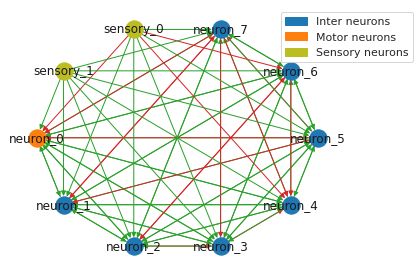

In [12]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ltc_cell.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

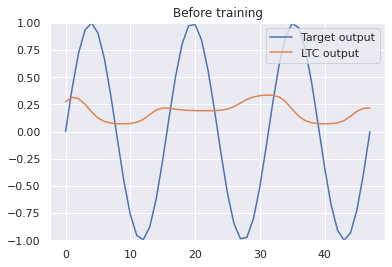

In [13]:
# Let's visualize how LTC initialy performs before the training
sns.set()
prediction = model(data_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output")
plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

In [14]:
# Train the model for 400 epochs (= training steps)
hist = model.fit(x=data_x, y=data_y, batch_size=1, epochs=100,verbose=1)

Epoch 1/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5163
Epoch 2/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4891
Epoch 3/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4845
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4858
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4852
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4815
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4766
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4722
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4693
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4681
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4676
Epoch 12/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4665
Epoch 13/100
1/1 [==============================] - 0s 1ms/st

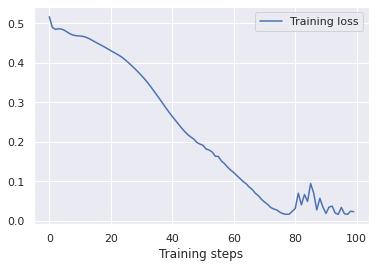

In [15]:
# Let's visualize the training loss
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Training loss")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.show()

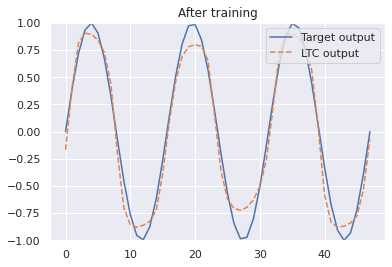

In [16]:
# How does the trained model now fit to the sinusoidal function?
prediction = model(data_x).numpy()
plt.figure(figsize=(6, 4))
plt.plot(data_y[0, :, 0], label="Target output")
plt.plot(prediction[0, :, 0], label="LTC output",linestyle="dashed")
plt.ylim((-1, 1))
plt.legend(loc="upper right")
plt.title("After training")
plt.show()

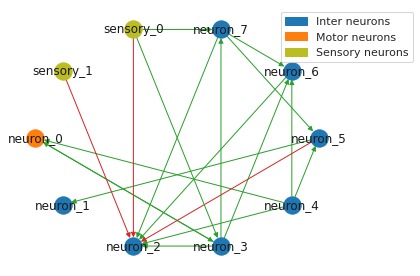

In [19]:
# Define LTC cell and wiring architecture
rnd_wiring = kncp.wirings.Random(8, 1,sparsity_level=0.75)  # 8 units, 1 motor neuron
sparse_cell = kncp.LTCCell(rnd_wiring)

# Define Keras model
sparse_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        keras.layers.RNN(sparse_cell, return_sequences=True),
    ]
)
sparse_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)

# Plot the wiring
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = sparse_cell.draw_graph(draw_labels=True)
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

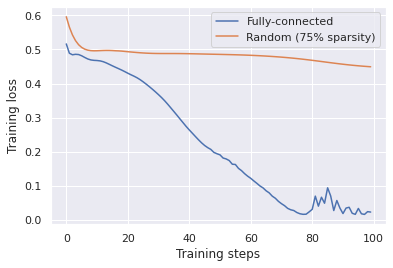

In [20]:
hist_rand = sparse_model.fit(x=data_x, y=data_y, batch_size=1, epochs=100,verbose=0)
# This may take a while (training the sprase LTC model)
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Fully-connected")
plt.plot(hist_rand.history["loss"], label="Random (75% sparsity)")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.show()

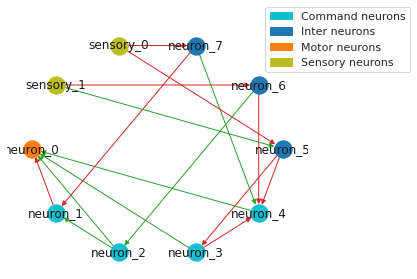

In [31]:
ncp_arch = kncp.wirings.NCP(
    inter_neurons=3,  # Number of inter neurons
    command_neurons=4,  # Number of command neurons
    motor_neurons=1,  # Number of motor neurons
    sensory_fanout=2,  # How many outgoing synapses has each sensory neuron
    inter_fanout=2,  # How many outgoing synapses has each inter neuron
    recurrent_command_synapses=3,  # Now many recurrent synapses are in the
    # command neuron layer
    motor_fanin=4,  # How many incomming syanpses has each motor neuron
)
ncp_cell = kncp.LTCCell(ncp_arch)

ncp_model = keras.models.Sequential(
    [
        keras.layers.InputLayer(input_shape=(None, 2)),
        keras.layers.RNN(ncp_cell, return_sequences=True),
    ]
)
ncp_model.compile(
    optimizer=keras.optimizers.Adam(0.01), loss='mean_squared_error'
)
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_cell.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

Epoch 1/100
1/1 [==============================] - 0s 1ms/step - loss: 0.6245
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.5280
Epoch 3/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4922
Epoch 4/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4860
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4787
Epoch 6/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4605
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4360
Epoch 8/100
1/1 [==============================] - 0s 1ms/step - loss: 0.4129
Epoch 9/100
1/1 [==============================] - 0s 1ms/step - loss: 0.3966
Epoch 10/100
1/1 [==============================] - 0s 1ms/step - loss: 0.3872
Epoch 11/100
1/1 [==============================] - 0s 1ms/step - loss: 0.3815
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3755
Epoch 13/100
1/1 [==============================] - 0s 2ms/st

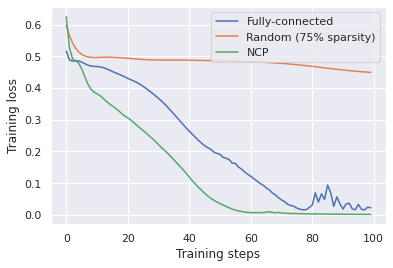

In [29]:
hist_ncp = ncp_model.fit(x=data_x, y=data_y, batch_size=1, epochs=100,verbose=1)
# This may take a while (training the LTC model)
sns.set()
plt.figure(figsize=(6, 4))
plt.plot(hist.history["loss"], label="Fully-connected")
plt.plot(hist_rand.history["loss"], label="Random (75% sparsity)")
plt.plot(hist_ncp.history["loss"], label="NCP")
plt.legend(loc="upper right")
plt.xlabel("Training steps")
plt.ylabel("Training loss")
plt.show()

In [30]:
# Let's compare how many synapses the NCP network has compared to the fully-connected one
sparsity = 1 - ncp_cell.synapse_count /ltc_cell.synapse_count
print("Sparsity level is {:0.2f}%".format(100*sparsity))

Sparsity level is -76.56%


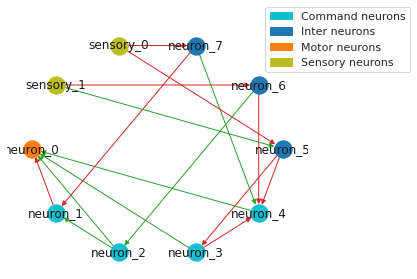

In [27]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = ncp_cell.draw_graph(draw_labels=True, neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1.1, 1.1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()